In [2]:
from pysr import PySRRegressor, TemplateExpressionSpec

import matplotlib.pyplot as plt
import numpy as np

import camb

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [3]:
plt.rcParams['font.family'] = 'stixgeneral'

In [4]:
# Load Data
pars     = np.load('CL_data/parameter_test9.npy')  # [H0, ombh2, omch2 ] x 100
lensed   = np.load('CL_data/lensed_CL9.npy')     # [C_2, ..., C_5000] x 100 (lensed)
unlensed = np.load('CL_data/unlensed_CL9.npy')     # [C_2, ..., C_5000] x 100 (unlensed)

In [5]:
pars_pysr = pars

In [9]:
def clamp(z, high, low):
    return (1/(1+np.exp(z)))*(high-low) + low

In [56]:
def lensing_tail_fit(ell, ombh2, omch2):
    beta_1, beta_2, beta_3, beta_4 = [5.517903e-10, 0.80629647, 3.7667117, 6.858553]
    beta_3 = clamp(beta_3, 1500, 2500)
    beta_4 = clamp(beta_4, 100, 600)
    x2 = ombh2 + omch2 
    x1 = ombh2
    
    # Exponent
    #alpha = (ombh2**-0.877) * (ombh2 + omch2) - 3.342*(ombh2 + omch2) - 1.118
    alpha = x2 + 2.4442892
        
    
    # Sigmoid
    #sigm = (-1/np.sinh(beta_3*(ell-beta_4)))**(-1)
    #sigm = (1 + np.exp(-(ell-beta_3)/125))**(-1)
    sigm = (1 + np.exp(-(ell-beta_3)/beta_4))**(-1)


    # Polynomial
    poly = (beta_1*(ell/beta_2)**alpha - 1)
    
    L = poly*sigm + 1

    return L


In [57]:
def return_error(func):
    return [100*np.abs(func(ells, pars_pysr[ind, 1], pars_pysr[ind, 2]) - lensed[ind]/unlensed[ind])/(lensed[ind]/unlensed[ind]) for ind in range(0, 100)]

In [58]:
ells = np.array([l for l in range(2, 5000)])
error = return_error(lensing_tail_fit)

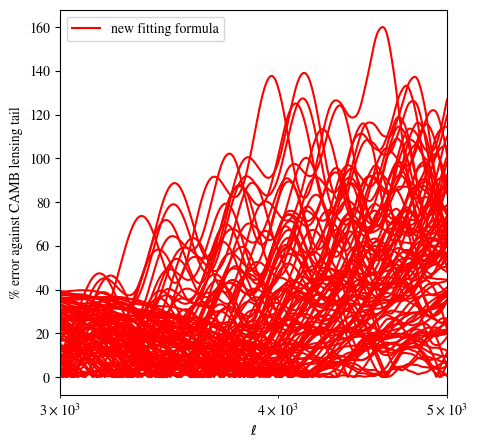

In [59]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
# Fit % Error for 100 Cosmologies
for ind in range(0, 100):
    ax.semilogx(ells, error[ind], "r", label='new fitting formula')


ax.set_xlim(3000, 5000)
ax.set_xlabel("$\\ell$")

ax.set_ylabel("% error against CAMB lensing tail")


handles, labels = fig.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax.legend(newHandles, newLabels)

In [60]:
def plot_scatter(error):
    fig,ax = plt.subplots()
    for i in range(len(error)):
        a = ax.scatter(pars[i][1], pars[i][2],s=5, c = np.mean(error[i]), cmap = "Reds", vmax = np.mean(error) + np.std(error), vmin =  np.mean(error) - np.std(error))
    #plt.scatter(fid_ombh2, fid_omch2, color = "black", s= 10, marker = "x", label = "Fiducial Cosmology (reference)")
    fig.colorbar(a, ax=ax, label = "Mean % Error")
    plt.xlabel("$\Omega_bh^2$")
    plt.ylabel("$\Omega_ch^2$")

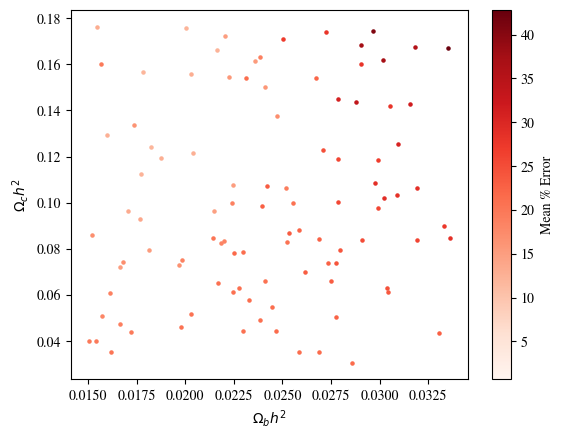

In [61]:
plot_scatter(error)

In [62]:
def get_lensing_camb(omb, omc):
    pars = camb.set_params(H0 = 67.4, ombh2 = omb, omch2 = omc, lmax=5000)
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    lensed = powers['total'][2:5000, 0]
    unlensed = powers['unlensed_total'][2:5000, 0]
    return lensed/unlensed

In [63]:
ombs = [0.02, 0.022, 0.022, 0.022, 0.022, 0.022]
omcs = [0.1, 0.1, 0.12, 0.15, 0.18, 0.19]

ombs = [0.02, 0.022, 0.022]
omcs = [0.1, 0.1, 0.12]

n = len(omcs)
#lensings_camb = [get_lensing_camb(ombs[i], omcs[i]) for i in range(n)]

In [64]:
lensings_fit = [lensing_tail_fit(ells, ombs[i], omcs[i]) for i in range(n)]

In [65]:
label_key = ["$\Omega_bh^2$ = " + str(ombs[i]) + ", $\Omega_ch^2$ = " + str(omcs[i]) for i in range(n)]

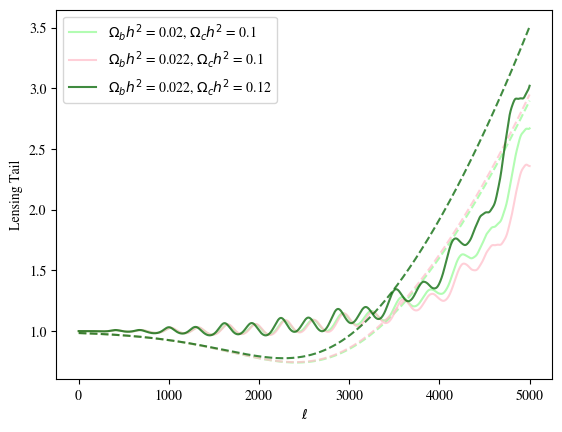

In [66]:
color_key = ["palegreen", "pink", "darkgreen", "darkmagenta", "slateblue", "aqua"]
for i in range(n):
    plt.plot(ells, lensings_fit[i], color = color_key[i], linestyle = "dashed", alpha = 0.75)
    plt.plot(ells, lensings_camb[i], color = color_key[i], label = label_key[i], alpha = 0.75)
plt.xlabel("$\\ell$")
plt.ylabel("Lensing Tail")
#plt.ylim(0.9,3)
plt.legend()

BELOW IS MISC LATEX

$$L(\ell) = 1 + w(\ell) \big[ \beta_1 \cdot \big(\frac{\ell}{\beta_2}\big)^{\alpha_{SR}(\Omega_bh^2, \Omega_m h^2)} -1 \big]$$

$$w(\ell) = \frac{1}{1+e^{-(\ell - \beta_3)/h_{SR}(\Omega_mh^2)}}$$

$$\alpha = 10.151914 - (\Omega_bh^2 * 60.48643) $$

$$h = ((\Omega_bh^2 + \Omega_ch^2) * -9338.021) + -29.82294$$

$$\beta= 1.3209447\times 10^{-9}, 298.32043, 0.04365817$$

$$L(\ell) = 1 + w(\ell) \big[ \beta_1 \cdot \big(\frac{\ell}{\beta_2}\big)^{\alpha_{SR}(\Omega_bh^2, \Omega_m h^2)} -1 \big]$$

$$w(\ell) = -\frac{1}{\tanh{\big(\beta_3 \cdot (\ell - \beta_4)\big)}}$$

$$\alpha_{SR} = ((\Omega_bh^2 + \Omega_ch^2) \cdot 2.794036) + (4.0606356 - (\Omega_bh^2 \cdot 25.646933))$$

$$\beta = 1.2210173\times 10^{-9}, \, 13.453718, \, -3.3733075 \times 10^{-5}, \, -0.45380783$$